- requires [numpy](http://numpy.scipy.org) and netCDF/HDF5 C libraries.
- Online docs: http://unidata.github.io/netcdf4-python/
- Based on Konrad Hinsen's old [Scientific.IO.NetCDF](http://dirac.cnrs-orleans.fr/plone/software/scientificpython/) API, with lots of added netcdf version 4 features.
- Heavily based on Jeff Whitaker's [Reading/Writing netCDF] (https://github.com/Unidata/netcdf4-python/tree/master/examples).

# Reading netCDF data

## Interactively exploring a netCDF File

first, import netcdf4-python and numpy

In [1]:
import netCDF4
import numpy as np

## Create a netCDF4.Dataset object
- **`f`** is a `Dataset` object, representing an open netCDF file.
- printing the object gives you summary information, similar to *`ncdump -h`*.

In [2]:
f = netCDF4.Dataset('../OISST/OISST_1982-2010.nc', 'r')
print(f) 

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): X(360), T(348), Y(181)
    variables(dimensions): float32 X(X), float32 T(T), float32 Y(Y), float32 sst(T,Y,X)
    groups: 



## List the netCDF variable
- variable objects stored by name in **`variables`** dict.
- print the variable yields summary info (including all the attributes).
- no actual data read yet (just have a reference to the variable object with metadata).

In [3]:
print(f.variables.keys()) # get all variable keys

odict_keys(['X', 'T', 'Y', 'sst'])


In [4]:
sst = f.variables['sst']
sst

<class 'netCDF4._netCDF4.Variable'>
float32 sst(T, Y, X)
    calendar: standard
    process: 44
    gribleveltype: 1
    subcenter: 4
    gribcenter: 160
    PDS_TimeRange: 1
    center: 160
    standard_name: Sea Surface Temperature
    gribNumBits: 12
    grib_name: TMP
    long_name: Sea Surface Temperature
    gribparam: 11
    GRIBgridcode: 3
    PTVersion: 2
    gribfield: 1
    units: Celsius_scale
unlimited dimensions: 
current shape = (348, 181, 360)
filling on, default _FillValue of 9.969209968386869e+36 used

## List the Dimensions

- dimension objects stored by name in **`dimensions`** dict.

In [5]:
f.dimensions

OrderedDict([('X',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'X', size = 360),
             ('T',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'T', size = 348),
             ('Y',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'Y', size = 181)])

Each variable has a **`dimensions`** and a **`shape`** attribute.

In [6]:
sst.dimensions

('T', 'Y', 'X')

In [7]:
sst.shape

(348, 181, 360)

### Each dimension typically has a variable associated with it (called a *coordinate* variable).
- *Coordinate variables* are 1D variables that have the same name as dimensions.
- Coordinate variables and *auxiliary coordinate variables* (named by the *coordinates* attribute) locate values in time and space.

In [8]:
lons,lats = f.variables['X'], f.variables['Y']
print(lons, lats)                 

<class 'netCDF4._netCDF4.Variable'>
float32 X(X)
    standard_name: longitude
    pointwidth: 1.0
    gridtype: 1
    units: degree_east
unlimited dimensions: 
current shape = (360,)
filling on, default _FillValue of 9.969209968386869e+36 used
 <class 'netCDF4._netCDF4.Variable'>
float32 Y(Y)
    standard_name: latitude
    pointwidth: 1.0
    gridtype: 0
    units: degree_north
unlimited dimensions: 
current shape = (181,)
filling on, default _FillValue of 9.969209968386869e+36 used



## Accessing data from a netCDF variable object

- netCDF variables objects behave much like numpy arrays.
- slicing a netCDF variable object returns a numpy array with the data.
- Boolean array and integer sequence indexing behaves differently for netCDF variables than for numpy arrays. Only 1-d boolean arrays and integer sequences are allowed, and these indices work independently along each dimension (similar to the way vector subscripts work in fortran).

In [9]:
sst.shape

(348, 181, 360)

In [10]:
sst[0, :, :]

masked_array(
  data=[[-1.72998046875, -1.72998046875, -1.72998046875, ...,
         -1.72998046875, -1.72998046875, -1.72998046875],
        [-1.709991455078125, -1.709991455078125, -1.709991455078125, ...,
         -1.720001220703125, -1.709991455078125, -1.709991455078125],
        [-1.67999267578125, -1.67999267578125, -1.67999267578125, ...,
         -1.67999267578125, -1.67999267578125, -1.67999267578125],
        ...,
        [-1.79998779296875, -1.79998779296875, -1.79998779296875, ...,
         -1.79998779296875, -1.79998779296875, -1.79998779296875],
        [-1.79998779296875, -1.79998779296875, -1.79998779296875, ...,
         -1.79998779296875, -1.79998779296875, -1.79998779296875],
        [-1.79998779296875, -1.79998779296875, -1.79998779296875, ...,
         -1.79998779296875, -1.79998779296875, -1.79998779296875]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, 

shape= (181, 360) , type= <class 'numpy.ma.core.MaskedArray'>


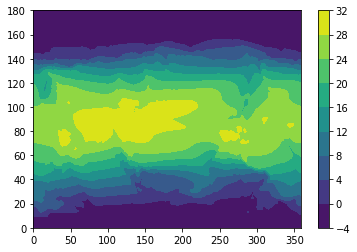

In [11]:
sst_avg = sst[:].mean(axis=0)
print('shape=', sst_avg.shape, ', type=', type(sst_avg))

import matplotlib.pyplot as plt
%matplotlib inline
cs = plt.contourf(sst_avg)
plt.colorbar()

## *Remote data access via openDAP

- Remote data can be accessed seamlessly with the netcdf4-python API
- Access happens via the DAP protocol and DAP servers, such as TDS.
- many formats supported, like GRIB, are supported "under the hood".

The following example showcases some nice netCDF features:

1. We are seamlessly accessing **remote** data, from a TDS server.
2. We are seamlessly accessing **GRIB2** data, as if it were netCDF data.
3. We are generating **metadata** on-the-fly.

In [12]:
import datetime
date = datetime.datetime.now()
# build URL for latest synoptic analysis time
URL = 'http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg/GFS_Global_0p5deg_%04i%02i%02i_%02i%02i.grib2/GC' %\
(date.year,date.month,date.day-2,6*(date.hour//6),0)
# keep moving back 6 hours until a valid URL found
validURL = False; ncount = 0
while (not validURL and ncount < 10):
    print(URL)
    try:
        gfs = netCDF4.Dataset(URL)
        validURL = True
    except RuntimeError:
        date -= datetime.timedelta(hours=6)
        ncount += 1       

http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg/GFS_Global_0p5deg_20180819_1200.grib2/GC


In [13]:
# Look at metadata for a specific variable
# gfs.variables.keys() will show all available variables.
sfctmp = gfs.variables['Temperature_surface']
# get info about sfctmp
print(sfctmp)
# print coord vars associated with this variable
for dname in sfctmp.dimensions:   
    print(gfs.variables[dname])

<class 'netCDF4._netCDF4.Variable'>
float32 Temperature_surface(time1, lat, lon)
    long_name: Temperature @ Ground or water surface
    units: K
    abbreviation: TMP
    missing_value: nan
    grid_mapping: LatLon_Projection
    coordinates: reftime time1 lat lon 
    Grib_Variable_Id: VAR_0-0-0_L1
    Grib2_Parameter: [0 0 0]
    Grib2_Parameter_Discipline: Meteorological products
    Grib2_Parameter_Category: Temperature
    Grib2_Parameter_Name: Temperature
    Grib2_Level_Type: 1
    Grib2_Level_Desc: Ground or water surface
    Grib2_Generating_Process_Type: Forecast
unlimited dimensions: 
current shape = (93, 361, 720)
filling off

<class 'netCDF4._netCDF4.Variable'>
float64 time1(time1)
    units: Hour since 2018-08-19T12:00:00Z
    standard_name: time
    long_name: GRIB forecast or observation time
    calendar: proleptic_gregorian
    _CoordinateAxisType: Time
unlimited dimensions: 
current shape = (93,)
filling off

<class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
   

## *Dealing with dates and times
- time variables usually measure relative to a fixed date using a certain calendar, with units specified like ***`hours since YY:MM:DD hh-mm-ss`***.
- **`num2date`** and **`date2num`** convenience functions provided to convert between these numeric time coordinates and handy python datetime instances.  
- **`date2index`** finds the time index corresponding to a datetime instance.

In [14]:
from netCDF4 import num2date, date2num, date2index
timedim = sfctmp.dimensions[0] # time dim name
print('name of time dimension = %s' % timedim)
times = gfs.variables[timedim] # time coord var
print(times)

name of time dimension = time1
<class 'netCDF4._netCDF4.Variable'>
float64 time1(time1)
    units: Hour since 2018-08-19T12:00:00Z
    standard_name: time
    long_name: GRIB forecast or observation time
    calendar: proleptic_gregorian
    _CoordinateAxisType: Time
unlimited dimensions: 
current shape = (93,)
filling off



In [15]:
dates = num2date(times[:], times.units)
print([date.strftime('%Y-%m-%d %H:%M:%S') for date in dates[:10]]) # print only first ten...

['2018-08-19 12:00:00', '2018-08-19 15:00:00', '2018-08-19 18:00:00', '2018-08-19 21:00:00', '2018-08-20 00:00:00', '2018-08-20 03:00:00', '2018-08-20 06:00:00', '2018-08-20 09:00:00', '2018-08-20 12:00:00', '2018-08-20 15:00:00']


### Get index associated with a specified date, extract forecast data for that date.

In [16]:
from datetime import datetime, timedelta
date = datetime.now() + timedelta(days=3)
print(date)
ntime = date2index(date,times,select='nearest')
print('index = %s, date = %s' % (ntime, dates[ntime]))

2018-08-24 16:35:08.549876
index = 42, date = 2018-08-24 18:00:00


## Closing your netCDF file

It's good to close netCDF files, but not actually necessary when Dataset is open for read access only.


In [17]:
f.close()
gfs.close()

# Writing netCDF data


## Opening a file, creating a new Dataset

Let's create a new, empty netCDF file named `../OISST/sample_nc_file.nc`, opened for writing.

Be careful, opening a file with`'w'` will clobber any existing data (unless `clobber=False` is used, in which case an exception is raised if the file already exists).

- `mode='r'` is the default.
- `mode='a'` opens an existing file and allows for appending (does not clobber existing data)
- `format` can be one of `NETCDF3_CLASSIC`, `NETCDF3_64BIT`, `NETCDF4_CLASSIC` or `NETCDF4` (default). `NETCDF4_CLASSIC` uses HDF5 for the underlying storage layer (as does `NETCDF4`) but enforces the classic netCDF 3 data model so data can be read with older clients.  

In [18]:
nc_file = netCDF4.Dataset('../OISST/sample_nc_file.nc',mode='w',format='NETCDF4_CLASSIC') 
print(nc_file)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 



## Creating global attributes

The **nc_file** object we created is a container for _dimensions_, _variables_, and _attributes_.   First, let's create some global attribtes.

netCDF attributes can be created just like you would for any python object. 

- Best to adhere to established conventions (like the [CF](http://cfconventions.org/) conventions)
- We won't try to adhere to any specific convention here though.

In [19]:
nc_file.setncattr(name="description", value="this is just a netCDF smaple file.")
nc_file.setncattr("created time", str(date.today()))
nc_file.version = "1.0"
print(nc_file)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    description: this is just a netCDF smaple file.
    created time: 2018-08-21 16:35:08.683884
    version: 1.0
    dimensions(sizes): 
    variables(dimensions): 
    groups: 



## Creating dimensions

dimensions should be created using the [`createDimension`](http://unidata.github.io/netcdf4-python/netCDF4.Dataset-class.html#createDimension) method.  

- Every dimension has a name and a length.  
- The name is a string that is used to specify the dimension to be used when creating a variable, and as a key to access the dimension object in the `nc_file.dimensions` dictionary.

Setting the dimension length to `0` or `None` makes it unlimited, so it can grow. 

- For `NETCDF4` files, any variable's dimension can be unlimited.  
- For `NETCDF4_CLASSIC` and `NETCDF3*` files, only one per variable can be unlimited, and it must be the leftmost (fastest varying) dimension.

In [20]:
lat_dim = nc_file.createDimension('lat', 181)     # latitude axis
lon_dim = nc_file.createDimension('lon', 360)    # longitude axis
time_dim = nc_file.createDimension('time', None) # unlimited axis (can be appended to).
print(nc_file.dimensions)

OrderedDict([('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 181
), ('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 360
), ('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0
)])


## Creating variables

Now let's add some variables and store some data in them.  

- A variable has a name, a type, a shape, and some data values.  
- The shape of a variable is specified by a tuple of dimension names.  
- A variable should also have some named attributes, such as 'units', that describe the data.

The [`createVariable`](http://unidata.github.io/netcdf4-python/netCDF4.Dataset-class.html#createVariable) method takes 3 mandatory args.

- the 1st argument is the variable name (a string). This is used as the key to access the variable object from the `variables` dictionary.
- the 2nd argument is the datatype (most numpy datatypes supported).  
- the third argument is a tuple containing the dimension names (the dimensions must be created first).  Unless this is a `NETCDF4` file, any unlimited dimension must be the leftmost one.
- there are lots of optional arguments (many of which are only relevant when `format='NETCDF4'`) to control compression, chunking, fill_value, etc.


In [21]:
# create variables.
latitude = nc_file.createVariable('latitude', 'f4', ('lat'))
latitude.units = 'degrees_north'
latitude.long_name = 'latitude'
longitude = nc_file.createVariable('longitude', 'f4', ('lon'))
longitude.units = 'degrees_east'
longitude.long_name = 'longitude'
time = nc_file.createVariable('time', 'i4', ('time',))
time.units = 'month since 1800-01-01'
time.long_name = 'time'
# Define a 3D variable to hold the data
temp = nc_file.createVariable('temperature','f8',('time','lat','lon')) # note: unlimited dimension is leftmost
temp.units = 'Celsius Degree' # degrees Kelvin
print(temp)

<class 'netCDF4._netCDF4.Variable'>
float64 temperature(time, lat, lon)
    units: Celsius Degree
unlimited dimensions: time
current shape = (0, 181, 360)
filling on, default _FillValue of 9.969209968386869e+36 used



## Pre-defined variable attributes (read only)

The netCDF4 module provides some useful pre-defined Python attributes for netCDF variables, such as dimensions, shape, dtype, ndim. 

Note: since no data has been written yet, the length of the 'time' dimension is 0.

In [22]:
print("-- Some pre-defined attributes for variable temp:")
print("temp.dimensions:", temp.dimensions)
print("temp.shape:", temp.shape)
print("temp.dtype:", temp.dtype)
print("temp.ndim:", temp.ndim)

-- Some pre-defined attributes for variable temp:
temp.dimensions: ('time', 'lat', 'lon')
temp.shape: (0, 181, 360)
temp.dtype: float64
temp.ndim: 3


## Writing data into the created variables

To write data into a netCDF variable object, just treat it like a numpy array and assign values to a slice.

In [23]:
nlats = len(lat_dim); nlons = len(lon_dim); ntimes = 3
# Write latitudes, longitudes.
# Note: the ":" is necessary in these "write" statements
latitude[:] = -90. + (180./nlats)*np.arange(nlats) # south pole to north pole
longitude[:] = (180./nlats)*np.arange(nlons) # Greenwich meridian eastward
# create a 3D array of random numbers
data_arr = np.random.uniform(low=-30,high=30,size=(ntimes,nlats,nlons))
# Write the data.  This writes the whole 3D netCDF variable all at once.
temp[:,:,:] = data_arr  # Appends data along unlimited dimension
print("-- Wrote data, temp.shape is now ", temp.shape)
# read data back from variable (by slicing it), print min and max
print("-- Min/Max values:", temp[:,:,:].min(), temp[:,:,:].max())

-- Wrote data, temp.shape is now  (3, 181, 360)
-- Min/Max values: -29.999360456847143 29.999837911774


- You can just treat a netCDF Variable object like a numpy array and assign values to it.
- Variables automatically grow along unlimited dimensions (unlike numpy arrays)
- The above writes the whole 3D variable all at once,  but you can write it a slice at a time instead.

Note that we have not yet written any data to the time variable.  It automatically grew as we appended data along the time dimension to the variable `temp`, but the data is missing.

## Closing a netCDF file

It's **important** to close a netCDF file you opened for writing:

- flushes buffers to make sure all data gets written
- releases memory resources used by open netCDF files

In [24]:
# first print the Dataset object to see what we've got
print(nc_file)
# close the Dataset.
nc_file.close(); print('Dataset is closed!')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    description: this is just a netCDF smaple file.
    created time: 2018-08-21 16:35:08.683884
    version: 1.0
    dimensions(sizes): lat(181), lon(360), time(3)
    variables(dimensions): float32 latitude(lat), float32 longitude(lon), int32 time(time), float64 temperature(time,lat,lon)
    groups: 

Dataset is closed!


# *Advanced features

So far we've only exercised features associated with the old netCDF version 3 data model.  netCDF version 4 adds a lot of new functionality that comes with the more flexible HDF5 storage layer.  

Let's create a new file with `format='NETCDF4'` so we can try out some of these features.

In [25]:
ncfile = netCDF4.Dataset('../OISST/new.nc','w',format='NETCDF4')
print(ncfile)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 



## Creating Groups

netCDF version 4 added support for organizing data in hierarchical groups.

- analagous to directories in a filesystem. 
- Groups serve as containers for variables, dimensions and attributes, as well as other groups. 
- A `netCDF4.Dataset` creates a special group, called the 'root group', which is similar to the root directory in a unix filesystem. 

- groups are created using the [`createGroup`](http://unidata.github.io/netcdf4-python/netCDF4.Dataset-class.html#createGroup) method.
- takes a single argument (a string, which is the name of the Group instance).  This string is used as a key to access the group instances in the `groups` dictionary.

Here we create two groups to hold data for two different model runs.

In [26]:
grp1 = ncfile.createGroup('model_run1')
grp2 = ncfile.createGroup('model_run2')
for grp in ncfile.groups.items():
    print(grp)

('model_run1', <class 'netCDF4._netCDF4.Group'>
group /model_run1:
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
)
('model_run2', <class 'netCDF4._netCDF4.Group'>
group /model_run2:
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
)


Create some dimensions in the root group.

In [27]:
lat_dim = ncfile.createDimension('lat', 73)     # latitude axis
lon_dim = ncfile.createDimension('lon', 144)    # longitude axis
time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).

Now create a variable in grp1 and grp2.  The library will search recursively upwards in the group tree to find the dimensions (which in this case are defined one level up).

- These variables are create with **zlib compression**, another nifty feature of netCDF 4. 
- The data are automatically compressed when data is written to the file, and uncompressed when the data is read.  
- This can really save disk space, especially when used in conjunction with the [**least_significant_digit**](http://unidata.github.io/netcdf4-python/netCDF4.Dataset-class.html#createVariable) keyword argument, which causes the data to be quantized (truncated) before compression.  This makes the compression lossy, but more efficient.

In [28]:
temp1 = grp1.createVariable('temp',np.float64,('time','lat','lon'),zlib=True)
temp2 = grp2.createVariable('temp',np.float64,('time','lat','lon'),zlib=True)
for grp in ncfile.groups.items():  # shows that each group now contains 1 variable
    print(grp)

('model_run1', <class 'netCDF4._netCDF4.Group'>
group /model_run1:
    dimensions(sizes): 
    variables(dimensions): float64 temp(time,lat,lon)
    groups: 
)
('model_run2', <class 'netCDF4._netCDF4.Group'>
group /model_run2:
    dimensions(sizes): 
    variables(dimensions): float64 temp(time,lat,lon)
    groups: 
)


## Creating a variable with a compound data type

- Compound data types map directly to numpy structured (a.k.a 'record' arrays). 
- Structured arrays are akin to C structs, or derived types in Fortran. 
- They allow for the construction of table-like structures composed of combinations of other data types, including other compound types. 
- Might be useful for representing multiple parameter values at each point on a grid, or at each time and space location for scattered (point) data. 

Here we create a variable with a compound data type to represent complex data (there is no native complex data type in netCDF). 

- The compound data type is created with the [`createCompoundType`](http://unidata.github.io/netcdf4-python/netCDF4.Dataset-class.html#createCompoundType) method.

In [29]:
# create complex128 numpy structured data type
complex128 = np.dtype([('real',np.float64),('imag',np.float64)])
# using this numpy dtype, create a netCDF compound data type object
# the string name can be used as a key to access the datatype from the cmptypes dictionary.
complex128_t = ncfile.createCompoundType(complex128,'complex128')
# create a variable with this data type, write some data to it.
cmplxvar = grp1.createVariable('cmplx_var',complex128_t,('time','lat','lon'))
# write some data to this variable
# first create some complex random data
nlats = len(lat_dim); nlons = len(lon_dim)
data_arr_cmplx = np.random.uniform(size=(nlats,nlons))+1.j*np.random.uniform(size=(nlats,nlons))
# write this complex data to a numpy complex128 structured array
data_arr = np.empty((nlats,nlons),complex128)
data_arr['real'] = data_arr_cmplx.real; data_arr['imag'] = data_arr_cmplx.imag
cmplxvar[0] = data_arr  # write the data to the variable (appending to time dimension)
print(cmplxvar)
data_out = cmplxvar[0] # read one value of data back from variable
print(data_out.dtype, data_out.shape, data_out[0,0])

<class 'netCDF4._netCDF4.Variable'>
compound cmplx_var(time, lat, lon)
compound data type: {'names':['real','imag'], 'formats':['<f8','<f8'], 'offsets':[0,8], 'itemsize':16, 'aligned':True}
path = /model_run1
unlimited dimensions: time
current shape = (1, 73, 144)

{'names':['real','imag'], 'formats':['<f8','<f8'], 'offsets':[0,8], 'itemsize':16, 'aligned':True} (73, 144) (0.3877507, 0.620845)


## Creating a variable with a variable-length (vlen) data type

netCDF 4 has support for variable-length or "ragged" arrays. These are arrays of variable length sequences having the same type. 

- To create a variable-length data type, use the [`createVLType`](http://unidata.github.io/netcdf4-python/netCDF4.Dataset-class.html#createVLType) method.
- The numpy datatype of the variable-length sequences and the name of the new datatype must be specified.

In [30]:
vlen_t = ncfile.createVLType('i4', 'phony_vlen')

A new variable can then be created using this datatype.

In [31]:
vlvar = grp2.createVariable('phony_vlen_var', vlen_t, ('time','lat','lon'))

Since there is no native vlen datatype in numpy, vlen arrays are represented in python as object arrays (arrays of dtype `object`). 

- These are arrays whose elements are Python object pointers, and can contain any type of python object. 
- For this application, they must contain 1-D numpy arrays all of the same type but of varying length. 
- Fill with 1-D random numpy int64 arrays of random length between 1 and 10.

In [32]:
vlen_data = np.empty((nlats,nlons),object)
for i in range(nlons):
    for j in range(nlats):
        size = np.random.randint(1,10,size=1) # random length of sequence
        vlen_data[j,i] = np.random.randint(0,10,size=size)# generate random sequence
vlvar[0] = vlen_data # append along unlimited dimension (time)
print(vlvar)
print('data =\n',vlvar[:])

<class 'netCDF4._netCDF4.Variable'>
vlen phony_vlen_var(time, lat, lon)
vlen data type: int32
path = /model_run2
unlimited dimensions: time
current shape = (1, 73, 144)

data =
 [[[array([6]) array([2, 6, 0, 7, 6, 5]) array([7, 9, 9, 7, 7, 2, 5]) ...
   array([2]) array([6, 6, 0, 6, 4, 7]) array([3, 0, 8, 9, 3, 9, 9, 2])]
  [array([5, 9, 6, 3, 1, 9, 8]) array([5, 1, 2, 7, 0, 6, 5, 5])
   array([9, 3, 6, 9, 0, 8, 9, 2, 8]) ... array([9, 7, 1, 6])
   array([9, 2]) array([2, 5, 7, 9, 1, 3, 5, 5, 1])]
  [array([8, 5, 5, 5, 3, 7, 4, 9, 7]) array([7, 9, 8, 6, 2])
   array([1, 3, 2, 1, 9, 9]) ... array([3, 7, 4, 4, 7])
   array([1, 9, 2, 3, 4, 1, 1, 7]) array([9, 7])]
  ...
  [array([3, 4, 3, 7, 3, 1]) array([3, 5, 9, 0, 7, 9]) array([2, 5]) ...
   array([4, 2, 9, 4, 9, 0, 2, 6]) array([7, 4, 8, 9, 6, 5, 6, 9, 4])
   array([0, 0, 4, 1])]
  [array([0]) array([5, 6]) array([2]) ...
   array([8, 7, 1, 2, 0, 3, 8, 4, 1]) array([9, 9, 3, 5, 7, 4])
   array([8, 0])]
  [array([2, 8, 9, 8, 7]) array(

Close the Dataset and examine the contents with ncdump.

In [33]:
ncfile.close()
!ncdump -h ../OISST/new.nc

netcdf ../OISST/new {
types:
  compound complex128 {
    double real ;
    double imag ;
  }; // complex128
  int(*) phony_vlen ;
dimensions:
	lat = 73 ;
	lon = 144 ;
	time = UNLIMITED ; // (1 currently)

group: model_run1 {
  variables:
  	double temp(time, lat, lon) ;
  	complex128 cmplx_var(time, lat, lon) ;
  } // group model_run1

group: model_run2 {
  variables:
  	double temp(time, lat, lon) ;
  	phony_vlen phony_vlen_var(time, lat, lon) ;
  } // group model_run2
}


## Other interesting and useful projects using netcdf4-python

- [Xray](http://xray.readthedocs.org/en/stable/): N-dimensional variant of the core [pandas](http://pandas.pydata.org) data structure that can operate on netcdf variables.
- [Iris](http://scitools.org.uk/iris/): a data model to create a data abstraction layer which isolates analysis and visualisation code from data format specifics.  Uses netcdf4-python to access netcdf data (can also handle GRIB).
- [Biggus](https://github.com/SciTools/biggus): Virtual large arrays (from netcdf variables) with lazy evaluation.
- [cf-python](http://cfpython.bitbucket.org/): Implements the [CF](http://cfconventions.org) data model for the reading, writing and processing of data and metadata. 